# Labor 07 - Neurális hálózatok tanítása

### Kézzel írott számok III
Ebben a feladatban tanítani fogjuk a neurális hálózatunkat, hogy az képes legyen felismerni kézzel írott számjegyeket 0-9-ig.

### 1: Adatok beolvasása 
Importáljuk be a használni kívánt csomagokt és olvassuk be az adatokat

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

data = loadmat("Lab7data.mat")                      # adatok beolvasása
X = data["X"]
y = data ["y"]                                      # adatok elrendezése
del data
m = X.shape[0]
print('Shape of X and y in order:')
print(X.shape)
print(y.shape)

data = loadmat("Lab7Weights.mat")                   # súlyok beolvasása
w1 = np.array(data["Theta1"])
w2 = np.array(data["Theta2"])                       # súlyok elrendezése
print('Shape of w1 and w2 in order:')
print(w1.shape)
print(w2.shape)
del data

Shape of X and y in order:
(5000, 400)
(5000, 1)
Shape of w1 and w2 in order:
(25, 401)
(10, 26)


Amit érdemes megfigyelni a kezdeti adatainkon:
- A minták egy 5000x400-as mátrixba vannak rendezve, ami azt jenelnti, hogy az 5000 darab 20x20 pixeles képünk van. A képeket kiterítve tároljuk a mátrixban.
- Kimenetként egy számot várunk, melyek egy 5000x1-es vektorban vannak eltárolva.
- A háló működéséhez szükséges súlymátrixok rendre 25x401 és 10x26. Ez azt jelenti, hogy a 400 kezdeti bemeneti paramáterünk ki van egészítve a BIAS taggal és a rejtett rétegben 25 neuron található.
- A rejetett réteghez is csatolva van a BIAS tag és így teremti meg a kapcsolatot a második súlyvektor a 26 rejtett neuton és a 10 lehetséges kimenet között.

A háló működését tekintve egy elem 10 osztályba tartozási valószínűségét fogjuk vizsgálni, melyek közül a legnagyobbat választva (MaxPooling) fogjuk meghatározni a végső számot.

### 2: Adatok vizualizálása

Printing some random data ...


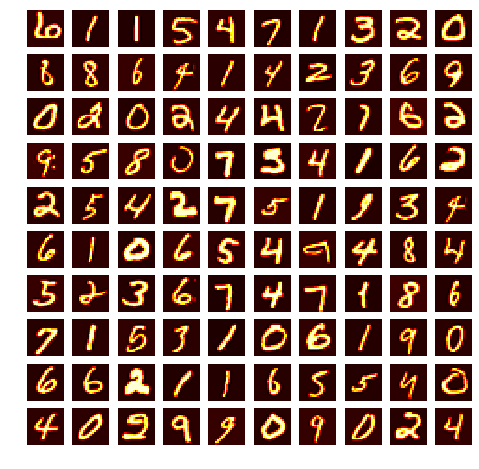

In [2]:
print("Printing some random data ...")                              
fig, ax = plt.subplots(10,10, figsize =(8,8))                  # subplots - 10x10 8x8as képnagysággal
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X[np.random.randint(0,m+1),:].reshape(20,20, order = "F"), cmap="hot")
        ax[i,j].axis("off")
plt.show()

### 3. Elméleti áttekintés

A könyebb megértés érdekében tekintsük az alábbi egyszerűsített példát. 

<img src="files/Pics/L07_Network.png">

A felvázolt neurális háló 3 rétegől áll.
- Bemeneti réteg, mely 2 bemeneti neuront tartalmaz plusz a hozzáadott BIAS tagot.
- Rejtett réteg, mely 3 neuront tartalmaz plusz a hozzárendelt BIAS tagot.
- Kimeneti réteg, mely 3 neuront tartalmaz, melyek közül a maximumot kiválasztva kapjuk meg a tényleges kimenetet.

A neuronok szerepét tekintve a BIAS neuronok kezelése kicsit eltérő. Mivel a BIAS nem változó, hanem egy konstans 1-es érték, hogy a hozzá tartozó súly egy független paraméter lehessen. Ennek megfelelően csak a súlyokkal való beszorzásnál van szerepe és minden réteghez igény szerint hozzá rendelhető. 

Jelöléseket tekintve vezessük be az alábbiakat: <br>
$a^{(j)}_{i}$ - j. réteg i. neuronjának aktivációja <br>
$s^{(j)}_{i}$ - j. réteg i. neuronjának szumma összege <br>
$w^{(j)}_{lk}$ - j. réteg l. neuronjából j+1. rltek k. neuronjába mutató súly (weight) <br>
$x^{(m)}_{n}$ - az m. bemeneti minta n. változója. ($x^{(1)}_0 = 1)$ a BIAS tag.<br> 
$\hat y$ - a kimenet

A forward lépést tehát az alábbiak szerint építhetjük fel: <br>
$x^{(1)}$-et kiegészítjük a BIAS taggal és beszorozzuk az első súlymátrixszal.

$ \underset{1\times 3}{\mathrm{x^{(1)}}} \times \underset{3\times 3}{\mathrm{w^{(1)}}} = \underset{1\times 3}{\mathrm{s^{(2)}}} $

Elvégezzük a rejtett réteg neuronjaiban az aktivációt. Aktivációs függvénynek használjuk a szigmoid függvényt.

$ \underset{\color{red}{1\times 3}}{\mathrm{a^{(2)}}} = f(\underset{1\times 3}{\mathrm{s^{(2)}}}) = sigmoid(\underset{1\times 3}{\mathrm{s^{(2)}}}) $ 

Hozzá rendeljük a BIAS tagot a rejtett réteghez az aktiváció után, de még a súly beszorzás előtt!

$ \underset{\color{red}{1\times 4}}{\mathrm{a^{(2)}}} \times \underset{4\times 3}{\mathrm{w^{(2)}}} = \underset{1\times 3}{\mathrm{s^{(3)}}}  $

Az aktivációt követően megkapjuk a kimeneti réteg neuronjoinak értékét. 

$ \underset{1\times 3}{\mathrm{a^{(3)}}} = f(\underset{1\times 3}{\mathrm{s^{(3)}}}) = sigmoid(\underset{1\times 3}{\mathrm{s^{(3)}}}) $

A kimeneti réteg a predikciónkat tartalmazza. 

$ \underset{1\times 3}{\mathrm{\hat{y}}} = \underset{1\times 3}{\mathrm{a^{(3)}}} $

Klasszifikációs probléma esetén a maximumot, vagyis a legvalószínűbb csoportot kiválasztva kaphatjuk meg a végső predikciót. 

#### Költség függvény

Költség függvénynek használjuk az eddig bevált MSE (Mean Square Error) módszert. Nézzük meg egy kimeneti neuron esetében hogyan alakul a hiba számítás. A BIASokat is figyelmen kívül hagyva koncentráljunk csak az ábrán sötét színnel ábrázolt kapcsolatokra. <br>

$ C = \sum\{\frac{1}{2}(y-\color{red}{\hat y})^2 \} $

$ C = \sum\{\frac{1}{2}(y-{\color{red}{a^{(3)}}})^2 \} $

$ C = \sum\{\frac{1}{2}(y-f({\color{red}{s^{(3)}}}))^2\} $

$ C = \sum\{\frac{1}{2}(y-f({\color{red}{a^{(2)}}}w^{(2)}))^2\} $

$ C = \sum\{\frac{1}{2}(y-f(f({\color{red}{s^{(2)}}})w^{(2)}))^2\}$

$ C = \sum\{\frac{1}{2}(y-f(f(xw^{(1)})w^{(2)}))^2\} $

A hiba számítás tehát visszavezethető a bemeneti változók és a hálóban szereplő súlyok függvényére. A formula tetszőleges számú rétegre alkalmazható.

#### Hiba visszaterjesztés (Back Propagation)
A hiba visszaterjesztés során a kimeneti rétegtől kezdve visszafelé kiszámoljuk, hogy az egyes neuronok mekkora mértékben felelősek a hiba kialakulásáért. Gyakorlatilag a költség függvény kiszámítása során használt lépéseket vissza fele kell elvégeznünk, ami azt jelenti szükségünk lesz az aktivációs függvény deriváltjára. <br>
##### Szigmoid függvény és deriváltja
$g(z) = \frac{1}{1+e^{-z}}$ <br>
$
\begin{split}
g'(z) = 
& = \frac{d}{dz}\frac{1}{1+e^{-z}} \\
& = \frac{1}{(1+e^{-z})^2}(e^{(-z)}) \\
& = \frac{1}{1+e^{-z}}(1-\frac{1}{(1+e^{-z})}) \\
& = g(z)(1-g(z))
\end{split}
$
<img src="files/Pics/07_SigmoidDeriv.png" width=400>

A hiba visszaterjesztéshes (Back propagation) a költség függvényt a megfelelő súlymátrix elemei szerint parciálisan deriválva kaphatjuk meg a hiba mértékét a rejtett réteg neuronjaiban. 

$ \begin{split}
\frac{\partial C}{\partial w^{(2)}} = \frac{\partial \sum \frac{1}{2}(y-\hat{y})^2}{\partial w^{(2)}} = \sum (\frac{\partial \frac{1}{2}(y-\hat{y})^2}{\partial w^{(2)}}) 
\end{split}$

A könnyebb átláthatóság miatt vezessük le egy elemre a deriválást. <br>

$
\begin{split}
\frac{\partial \frac{1}{2}(y-\hat{y})^2}{\partial w^{(2)}} 
& = (y-\hat{y})(-\frac{\hat{y}}{\partial w^{(2)}}) \\
& = -(y-\hat{y}) \cdot \frac{\partial \hat{y}}{\partial s^{(3)}}\cdot \frac{\partial 	s^{(3)}}{\partial w^{(2)}}\\	
& = \color{red}{-(y-\hat{y}) \cdot f'(s^{(3)})}\cdot
\frac{\partial a^{(2)}w^{(2)}}{\partial w^{(2)}}\\
& = {\color{red} {\delta^{(3)}}\cdot a^{(2)}}
\end{split}
$<br>

Vezesük be $ \delta^{(j)}_{i} $, mint a j. réteg i. neuronjához rendelt hibatagot. <br>
Mátrixos formában kibővítve a dimenziók ellenőrzése után a következő összefüggést kapjuk: <br>
$ (a^{(2)})^T \delta^{(3)} $


#### Tanítás
A tanító fázis során a korábban megismert módon a súlyokat a Gradiens Descent módszer segítségével módosítjuk. A súlymódosításhoz definiálnunk kell egy tanulási rátát $(\mu)$ és opcionálisan a büntető tagot is megadhatjuk. <br>

$ w^{(1)} = w^{(1)} - \mu \frac{\partial C}{w^{(1)}}+ regularization $

$ w^{(2)} = w^{(2)} - \mu \frac{\partial C}{w^{(2)}}+ regularization $

#### Algoritmus lépései
Foglaljuk össze az algoritmus megvalósítandó lépéseit

1, $\hspace{2mm} xw^{(1)} = s^{(2)} $

2, $\hspace{14mm} f(s^{(2)}) = a^{(2)}$ 

3, $\hspace{32mm} a^{(2)} w^{(2)} = s^{(3)} $

4, $\hspace{48mm} f(s^{(3)}) = \hat{y} $

5, $\hspace{2mm} C = \sum\{\frac{1}{2}(y-\hat y)^2 \} $

6, $\hspace{2mm} -(y-\hat{y}) \cdot f'(s^{(3)}) = \delta^{(3)} $

7, $\hspace{28mm} (a^{(2)})^T \delta^{(3)} =  \frac{\partial C}{\partial w^{(2)}} $

8, $\hspace{39mm} \delta ^{(3)} \cdot (w^{(2)})^T \cdot f'(s^{(2)})= \delta ^{(2)} $

9, $\hspace{78mm} x^T \delta^{(2)} =  \frac{\partial C}{\partial w^{(1)}} $

10, $\hspace{2mm} w^{(1)} = w^{(1)} - \mu \frac{\partial C}{w^{(1)}}+ regularization $

$\hspace{8mm}w^{(2)} = w^{(2)} - \mu \frac{\partial C}{w^{(2)}}+ regularization $

### 3: Paraméterek előkészítése

In [3]:
Lambda = 1                                              # Büntetés mértéke
input_layer_size = 400                                  # bemeneti réteg nagysága
hidden_layer_size = 25                                  # rejtett réteg nagysága
num_labels = 10                                         # labelek száma
nn_params = np.append(w1.flatten(), w2.flatten())       # kialapítjuk a w1 és w2-t és egymás után füzzük

Az architecktúra nyomonkövetése átláthatóbb, ha az egyes rétegek neuronszámait tároljuk a BIAS tagok nélkül. A súlyokat pedig kiterítve egy változóban kezeljük. A mátrixok méretei az egyes rétegek neuron számai alapján visszaállíthatóak. Továbbá szükségünk lesz a tanulási rátára, mint előre beállított paraméterre.

### 4: Költségfüggvény
A költség függvény implementálása előtt szükségünk lesz egy aktivációs függvényre és annak deriváltjára. Aktivációs függvénynek ismét a szigmoid függvényt választjuk.

In [4]:
def sigmoid(z):
##########################################    
    g = 1/(1+(np.exp(-z)))
##########################################    
    return g

def sigmoidGradient(z):
##########################################    
    g_deriv = sigmoid(z) * (1-sigmoid(z))
##########################################    
    return g_deriv

A költség függvény paraméterként meg fogja kapni a súly paramétereket, a háló rétegméreteit, illetve a mintákat, a mintákhoz tartozó cimkéket és a tanulási rátát. Mivel a súlyparamétereket egy változóban adjuk át a függvénynek, így a függvényen belül kell visszaállítanunk a megfelelő mátrix dimenziókat a súlymátrixoknak.

In [105]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    # nn_params visszaalakítása w1 és w2 mátriokká
    w1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size + 1)
    w2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size + 1)

    m = X.shape[0]
    C = 0
    w1_grad = np.zeros((w1.shape))
    w2_grad = np.zeros((w2.shape))

    # Forward Step
    #########################################################################################
    A1_B = np.hstack((np.ones((m, 1)), X))                # BIAS hozzáadása a bementi réteghez
    S2   = A1_B @ w1.T                                    # Rejtett réteg
    A2   = sigmoid(S2)
    A2_B = np.hstack((np.ones((A2.shape[0], 1)), A2))     
    S3   = A2_B @ w2.T                                    # Kimeneti réteg
    A3   = sigmoid(S3)
    
    y_hat = A3
    #########################################################################################
    
    # ONE HOT ENCODING (y to Y)
    #########################################################################################
    Y = np.zeros((m, num_labels))
    I = np.eye(num_labels)

    for i in range(1, m+1):
        Y[i-1, :] = I[y[i-1]-1, :]
    #########################################################################################

    #Penalty
    #########################################################################################
    penalty  = (Lambda / (2 * m)) *   ((np.sum(w1[:, 1:] ** 2)) + np.sum(w2[:,1:]**2)) 
    #########################################################################################
    
    # Cost Function
    #########################################################################################
    C = (1/m) * (np.sum((-Y)*np.log(y_hat)-((1-Y)*np.log(1-y_hat)))) + penalty
    #########################################################################################

    # Back Propagation
    #########################################################################################
    sigma3 = A3 - Y # Nincs sigmoid derivált, így nagyobb hiba érhető el és gyorsabb konvergencia
    sigma2 = (sigma3 @ w2) * sigmoidGradient(np.hstack((np.ones([S2.shape[0],1]), S2)))    
    sigma2 = sigma2[:, 1:]
    
    delta_1 = (sigma2.T @ A1_B)
    delta_2 = (sigma3.T @ A2_B)
    
    p1 = (Lambda/m) * np.hstack((np.zeros((w1.shape[0], 1)), w1[:, 1:]))
    p2 = (Lambda/m) * np.hstack((np.zeros((w2.shape[0], 1)), w2[:, 1:]))

    w1_grad = delta_1 / m + p1
    w2_grad = delta_2 / m + p2
    #########################################################################################
    grad = np.append(w1_grad.flatten(), w2_grad.flatten())

    return C, grad

In [111]:
Lambda = 3    
C, grad = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda)
print("Cost at debugging parameters: %.6f \nFor Lambda = 3 it should be:  0.576051" % C)

Cost at debugging parameters: 0.576051 
For Lambda = 3 it should be:  0.576051


### 5: Kezdeti súlyok

In [ ]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12

    W = np.random.rand(L_out,L_in+1)*(2*epsilon_init)-epsilon_init

    return W

In [ ]:
initial_w1 = randInitializeWeights(input_layer_size,hidden_layer_size)
initial_w2 = randInitializeWeights(hidden_layer_size,num_labels)
initial_nn_params = np.append(initial_w1.flatten(),initial_w2.flatten())

### 6: Grádiens módszer

In [ ]:
def gradientDescentnn(X, y, initial_nn_params, alpha, num_iters, Lambda, input_layer_size, hidden_layer_size,
                      num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha

    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size,
                                                                                      input_layer_size + 1)
    Theta2 = initial_nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size + 1)

    m = len(y)
    C_history = []

    for i in range(num_iters):
        if (i%20==0):
            print('Iteration:', i+1)
        elif (i==num_iters-1):
            print('Done!')
        nn_params = np.append(Theta1.flatten(), Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[
                             3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        C_history.append(cost)

    nn_paramsFinal = np.append(Theta1.flatten(), Theta2.flatten())
    return nn_paramsFinal, C_history


nnw, nnC_history = gradientDescentnn(X,Y,initial_nn_params,0.8,800,1,input_layer_size,hidden_layer_size,num_labels)
w1 = nnw[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
w2 = nnw[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Nem futtatjuk végig, csak egy nagyon kicsi részen, hogy lehessen látni mennyire lassú az általunk megírt nem optimalizált kód.... a kész eredményeket betöltjük inkább a következő cellában. Otthon ki lehet próbálni 800 iterációra hogy ugyanazt adja e ki...

In [ ]:
def predict(w1,w2,X):
    m = X.shape[0]

    a1 = np.column_stack((np.ones((m,1)),X))
    z2 = a1 @ w1.T
    a2 = np.column_stack((np.ones((m,1)),sigmoid(z2)))
    z3 = a2 @ w2.T
    a3 = sigmoid(z3)

    return np.argmax(a3,axis=1)+1

def accuracy(pred,Y):
    return (np.sum(pred[:,np.newaxis]==Y)/5000)*100

w1_r = np.loadtxt("w1_final.txt")
w2_r = np.loadtxt("w2_final.txt")

pred3 = predict(w1_r,w2_r,X)
acc = accuracy(pred3,Y)
print('Training Set Accuracy:',acc,'%')

### 7: Költségfüggvény az iterációk során

In [ ]:
nnC_history=np.loadtxt("nnC_history_800.txt")
plt.plot(nnC_history)
plt.xlabel('Iteration')
plt.ylabel('Cost function')
plt.title('Cost function over the iterations')
plt.show()